In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder


In [3]:
#laod data
df = pd.read_csv('/content/drive/MyDrive/Shared Folder Project 1/ Real-Time_Road_Conditions_20250116.csv')
df.columns

Index(['id', 'sensor_id', 'Location Name', 'Location', 'timestamp',
       'voltage_y', 'voltage_x', 'voltage_ratio', 'air_temp_secondary',
       'temp_surface', 'condition_code_displayed', 'condition_code_measured',
       'condition_text_displayed', 'condition_text_measured',
       'friction_code_displayed', 'friction_code_measured',
       'friction_value_displayed', 'friction_value_measured',
       'dirty_lens_score', 'grip_text', 'relative_humidity',
       'air_temp_primary', 'air_temp_tertiary', 'status_code'],
      dtype='object')

In [4]:
## all columns to lowercase
df.columns = df.columns.str.lower()
#renaming location column
df.rename(columns={'location name': 'location_name'}, inplace=True)
#renamin gthe 2222 location
df['location_name'] = df['location_name'].replace('2222 RD / LAKEWOOD DR', 'FM 2222 RD / LAKEWOOD DR')
#dropped a few columns
df = df.drop(columns= ["id", "location"]) ## dropped Id it is too specific to be of use
#converted to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce', format='%m/%d/%Y %I:%M:%S %p')


In [5]:
## cleaning of condition text
df['condition_text_displayed']= df['condition_text_displayed'].str.strip()
df['condition_text_displayed'].unique()
## cleaning of condition text
df['condition_text_displayed']= df['condition_text_displayed'].str.strip()
df['condition_text_displayed'].unique()
# Cleaning of grip text
df['grip_text']= df['grip_text'].str.strip()
df['grip_text'].unique()


array(['GOOD', 'FAIR', 'POOR'], dtype=object)

In [6]:
df_clean = df.drop(columns=['sensor_id','condition_code_displayed', 'condition_code_measured','condition_text_measured', 'friction_code_measured', 'friction_code_displayed', 'friction_value_measured'])

In [7]:
# Create the OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the encoder
encoded_data = encoder.fit_transform(df_clean[['condition_text_displayed','grip_text','status_code']]).toarray()

# Create a new DataFrame from the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['condition_text_displayed','grip_text','status_code']))

# join the encoded DataFrame with the original DataFrame
df_encoded = df_clean.join(encoded_df)


In [8]:
# Sample lens scores for demonstration
lens_scores = np.array([0, 2, 3, 6, 8, 9, 10])

class DirtyLensBinner(BaseEstimator, TransformerMixin):
    """Custom Transformer to categorize dirty and clean lens scores."""

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Convert the DataFrame to a copy to avoid modification
        X_copy = X.copy()
        # Apply binning logic based on the score
        X_copy['lens_bin'] = np.where(X_copy['dirty_lens_score'].isin([2, 6, 8]), 'dirty', 'clean')
        return X_copy

# Create and apply the transformer
binner = DirtyLensBinner()
df_transformed_binned = binner.fit_transform(df_encoded)

In [9]:
##drop encoded columns and location name
df_transformed = df_transformed_binned.drop(columns = ['condition_text_displayed','grip_text','status_code', 'dirty_lens_score'])

In [10]:
# Create a LabelEncoder
lb = LabelEncoder()

# Fit and transform the 'lens_status' column
df_transformed['lens_status'] = lb.fit_transform(df_transformed['lens_bin'])

# Create new columns
df_transformed['dirty_lens'] = (df_transformed['lens_bin'] == 'dirty').astype(int)
df_transformed['clean_lens'] = (df_transformed['lens_bin'] == 'clean').astype(int)

# Drop unnecessary columns
df_transformed.drop(['lens_status','lens_bin'], axis=1, inplace=True)

In [11]:
# Drop columns for better visualization of corr matrix
df_mask = df_encoded.drop(columns = ['location_name', 'timestamp', 'condition_text_displayed_DRY',
                                     'condition_text_displayed_ERR', 'condition_text_displayed_WT1','condition_text_displayed_MAX',
                                     'condition_text_displayed_WT2', 'condition_text_displayed_UNK', 'condition_text_displayed', 'grip_text', 'status_code'])


In [12]:
df_columns_renamed=['Voltage Y', 'Voltage X', 'Voltage Ratio', 'Secondary air temp',
       'Surface Temp','Friction Value',
       'Dirty Lens Score', 'Humidity',
       'Primary Air Temp', 'Tertiary Air Temp',
       'Ice', 'Blck Ice',
       'Snow', 'Standing Water',
       'Fair Grip', 'Good Grip', 'Poor Grip',
       'Needs Calibration', 'Calibrate Soon', 'Calibrated']


df_columns= list(df_mask)

df_cols_dict =dict(zip(df_columns,df_columns_renamed))
df_mask= df_mask.rename(columns= df_cols_dict)
df_mask.columns

Index(['Voltage Y', 'Voltage X', 'Voltage Ratio', 'Secondary air temp',
       'Surface Temp', 'Friction Value', 'Dirty Lens Score', 'Humidity',
       'Primary Air Temp', 'Tertiary Air Temp', 'Ice', 'Blck Ice', 'Snow',
       'Standing Water', 'Fair Grip', 'Good Grip', 'Poor Grip',
       'Needs Calibration', 'Calibrate Soon', 'Calibrated'],
      dtype='object')

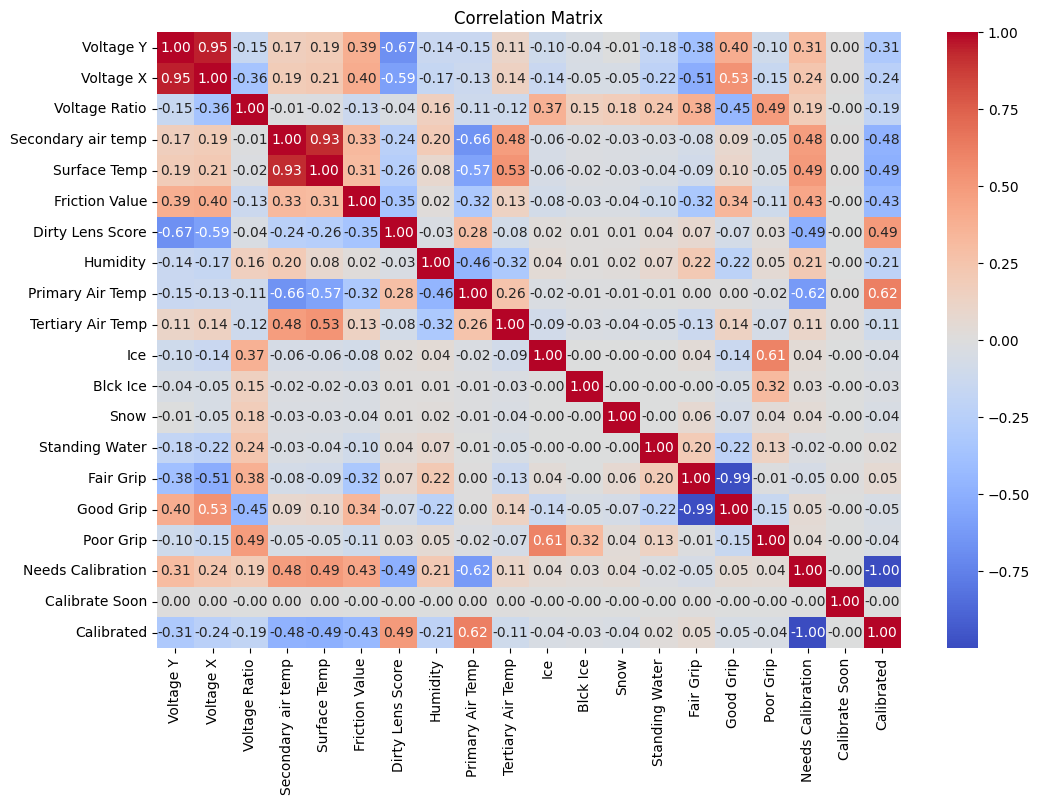

In [13]:
corr_matrix = df_mask.corr()
#Create the heatmap using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

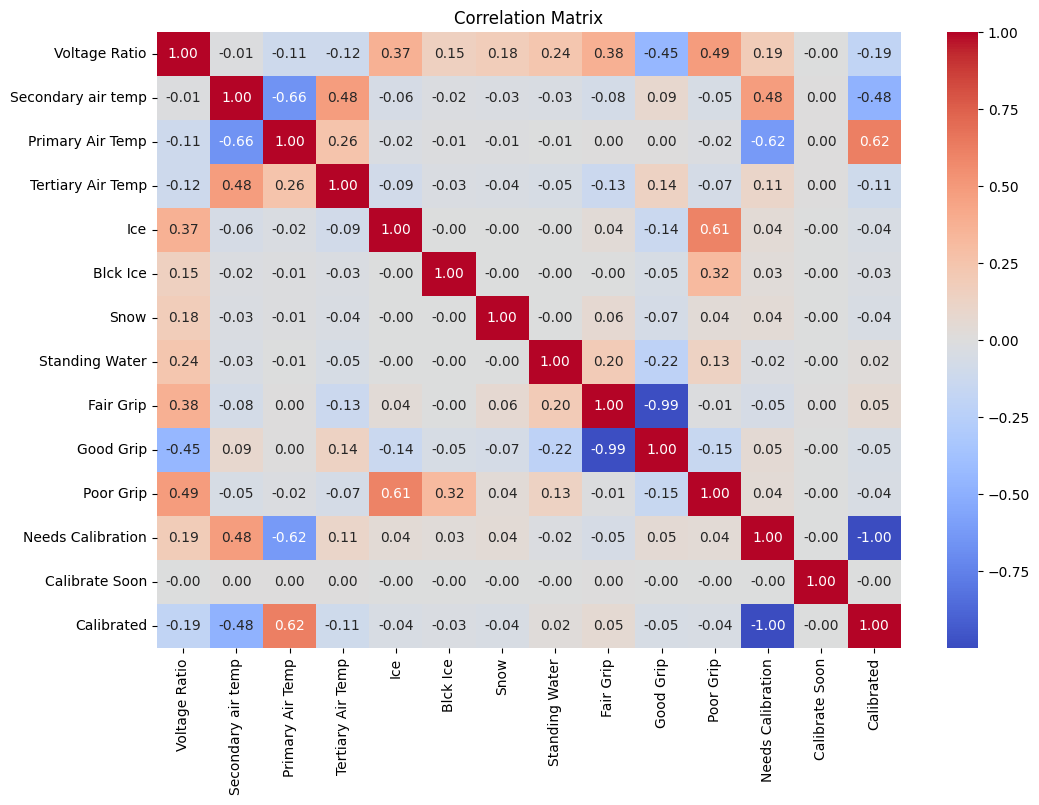

In [14]:
df_mask_condensed= df_mask.drop(columns= ['Voltage X', 'Voltage Y', 'Humidity', 'Surface Temp', 'Friction Value','Dirty Lens Score'])
##Condensed Heat Map
corr_matrix = df_mask_condensed.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [15]:
#changing location names
location_mapping = {
    'LAKELINE BLVD / 183 HWY SVRD': 'NORTH AUSTIN',
    'FM 2222 RD / LAKEWOOD DR': 'NORTH WEST AUSTIN',
    '11TH ST / 35 SVRD': 'DOWNTOWN',
    'BEN WHITE BLVD SVRD / BANISTER LN': 'SOUTH AUSTIN'
}
df['location_name'] = df['location_name'].replace(location_mapping)

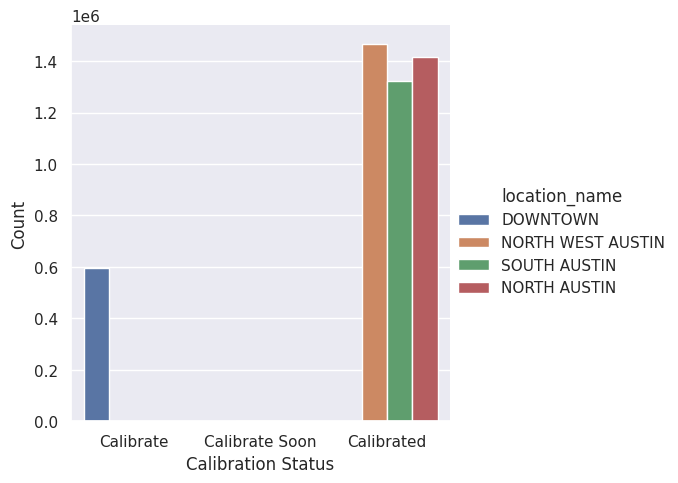

In [16]:
sns.set(rc={'figure.figsize': (25, 8)})
g = sns.catplot(
    x="status_code",
    hue="location_name",
    kind="count",
    data=df,
)

g.set_axis_labels("Calibration Status", "Count")
g.set_xticklabels(['Calibrate','Calibrate Soon','Calibrated'])
plt.show(g)

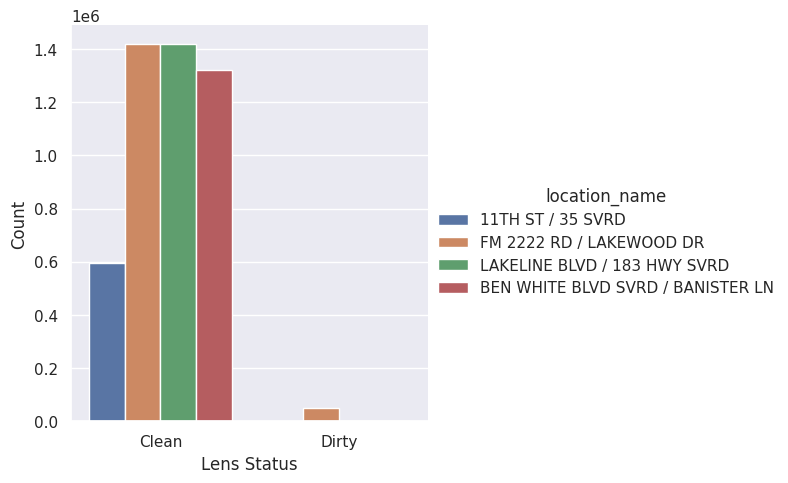

In [17]:
sns.set(rc={'figure.figsize': (25, 8)})
g = sns.catplot(
    x="lens_bin",
    hue="location_name",
    kind="count",
    data=df_transformed_binned,
)
g.set_axis_labels("Lens Status", "Count")
g.set_xticklabels(['Clean', 'Dirty'])

<ipython-input-19-fd80637d20be>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(df['location_name'].unique()))


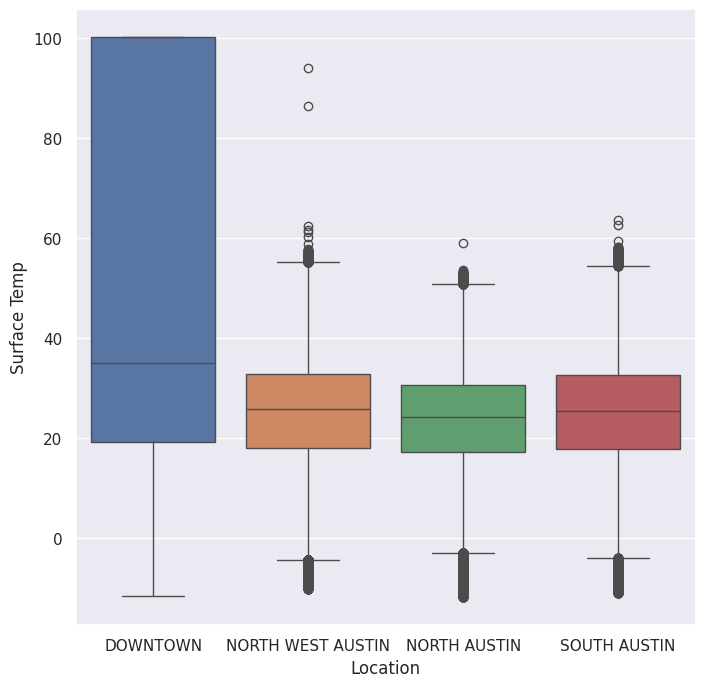

In [18]:
#surface temp by location

sns.set(rc={'figure.figsize':(8,8)})
ax= sns.boxplot(x='location_name',y='temp_surface', hue='location_name', data=df)
ax.set_xlabel("Location")
ax.set_ylabel("Surface Temp")

ax.set_xticklabels(list(df['location_name'].unique()))
plt.show(ax)

In [19]:
#Binned into Bad or Good Road Condition
class BadWeatherBinner(BaseEstimator, TransformerMixin):
    """Custom Transformer to categorize bad weather score."""

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Convert the DataFrame to a copy to avoid modification
        X_copy = X.copy()
        # Apply binning logic based on the score
        X_copy['road condition'] = np.where(X_copy['condition_code_displayed'].isin([5,6,7,8]), 'Bad ', 'Good')
        return X_copy

# Create and apply the transformer
weather_binner = BadWeatherBinner()
weather_df_binned = weather_binner.fit_transform(df)

In [43]:
##Look at extremes for each location
df.reset_index()
df_grouped= df.groupby(['location_name']).agg({'air_temp_primary':['min', 'idxm'],'air_temp_secondary':['min'], 'friction_value_displayed': ['min']}).reset_index()
df_grouped

AttributeError: 'SeriesGroupBy' object has no attribute 'idxm'

In [1]:
#lowest secondary temp

min_secondary= df.idxmin(axis=1)
min_secondary


In [21]:
##Downtown mask
df =df[df['location_name']!= 'DOWNTOWN']

In [23]:
#lowest friction
df['friction_value_displayed'].idxmin()
df.iloc[1158257]
#df['friction_value_displayed'].min()